Use decision trees to prepare a model on fraud data <br>
treating those who have taxable_income <= 30000 as "Risky" and others are "Good" <br>

Data Description :<br>

Undergrad : person is under graduated or not<br>
Marital.Status : marital status of a person<br>
Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government <br>
Work Experience : Work experience of an individual person<br>
Urban : Whether that person belongs to urban area or not<br>

In [32]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import pearsonr
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [33]:
df=pd.read_csv('Fraud_check.csv')
df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [34]:
# Describing about the data
df.describe(include='all')

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
count,600,600,600.000000,600.000000,600.000000,600
unique,2,3,NaN,NaN,NaN,2
top,YES,Single,NaN,NaN,NaN,YES
freq,312,217,NaN,NaN,NaN,302
mean,NaN,NaN,55208.375000,108747.368333,15.558333,NaN
std,NaN,NaN,26204.827597,49850.075134,8.842147,NaN
min,NaN,NaN,10003.000000,25779.000000,0.000000,NaN
25%,NaN,NaN,32871.500000,66966.750000,8.000000,NaN
50%,NaN,NaN,55074.500000,106493.500000,15.000000,NaN
75%,NaN,NaN,78611.750000,150114.250000,24.000000,NaN


Our data seems to be perfect, I Mean no outliers!

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [36]:
# Storing catagorical column and continious columns
cat_cols=[x for x in df.columns if df[x].dtype=='O']
cont_cols=[x for x in df.columns if x not in cat_cols]

In [37]:
# Exploring continious columns
for column in cont_cols:
    fig = make_subplots(
        rows=2, cols=2,specs=[
                                [{"rowspan": 2, "colspan": 1},{}],
                                [None,{}]
                             ])

    fig.add_trace(
        go.Histogram(x= df[column]),
        row=1, col=1)

    fig.add_trace(
        go.Box(x= df[column],
               boxpoints='all',
               name=''),
        row=1, col=2)

    fig.add_trace(
        go.Violin(x=  df[column],
                  meanline_visible=True,
                  box_visible=True,
                  name=''),
        row=2, col=2)

    fig.update_layout(showlegend=False,
                      title_text=f'<b>{column}</b> :<br> \t Skewness= {stats.skew(df[column]):.3f}, Kurtosis= {stats.kurtosis(df[column]):.3f}')
    fig.show()

None of them are from Normal Distribution<br>
All of them are free from outliers

In [38]:
# categorical variables
fig = make_subplots(rows=1, cols=3,subplot_titles=cat_cols)

for i,j in enumerate(cat_cols):
    fig.add_trace(go.Bar(x=df[j].value_counts().index, y=df[j].value_counts().values),row=1,col=i+1)
fig.update_layout(showlegend=False)
fig.show()

In [39]:
# making a copy
new_df=df.copy()

In [40]:
# Labelling our data
LE=LabelEncoder()
for i in cat_cols:
    new_df[i]=LE.fit_transform(new_df[i])
new_df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,0,2,68833,50047,10,1
1,1,0,33700,134075,18,1
2,0,1,36925,160205,30,1
3,1,2,50190,193264,15,1
4,0,1,81002,27533,28,0


In [41]:
# As description, those who have income less than 30000 are considered as risky and others are good
new_df.loc[new_df['Taxable.Income']<=30000,'Risk']=1
new_df.fillna(0,inplace=True)
new_df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Risk
0,0,2,68833,50047,10,1,0.0
1,1,0,33700,134075,18,1,0.0
2,0,1,36925,160205,30,1,0.0
3,1,2,50190,193264,15,1,0.0
4,0,1,81002,27533,28,0,0.0


Text(0, 0.5, '')

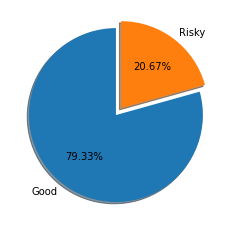

In [43]:
# Checking what percentage they are
new_df.Risk.value_counts().plot.pie( autopct='%1.2f%%', 
                                     explode=[0,0.1],
                                     startangle=90,
                                     labels=["Good","Risky"],
                                     shadow=True)
plt.ylabel('')

Clearly its an imbalanced data

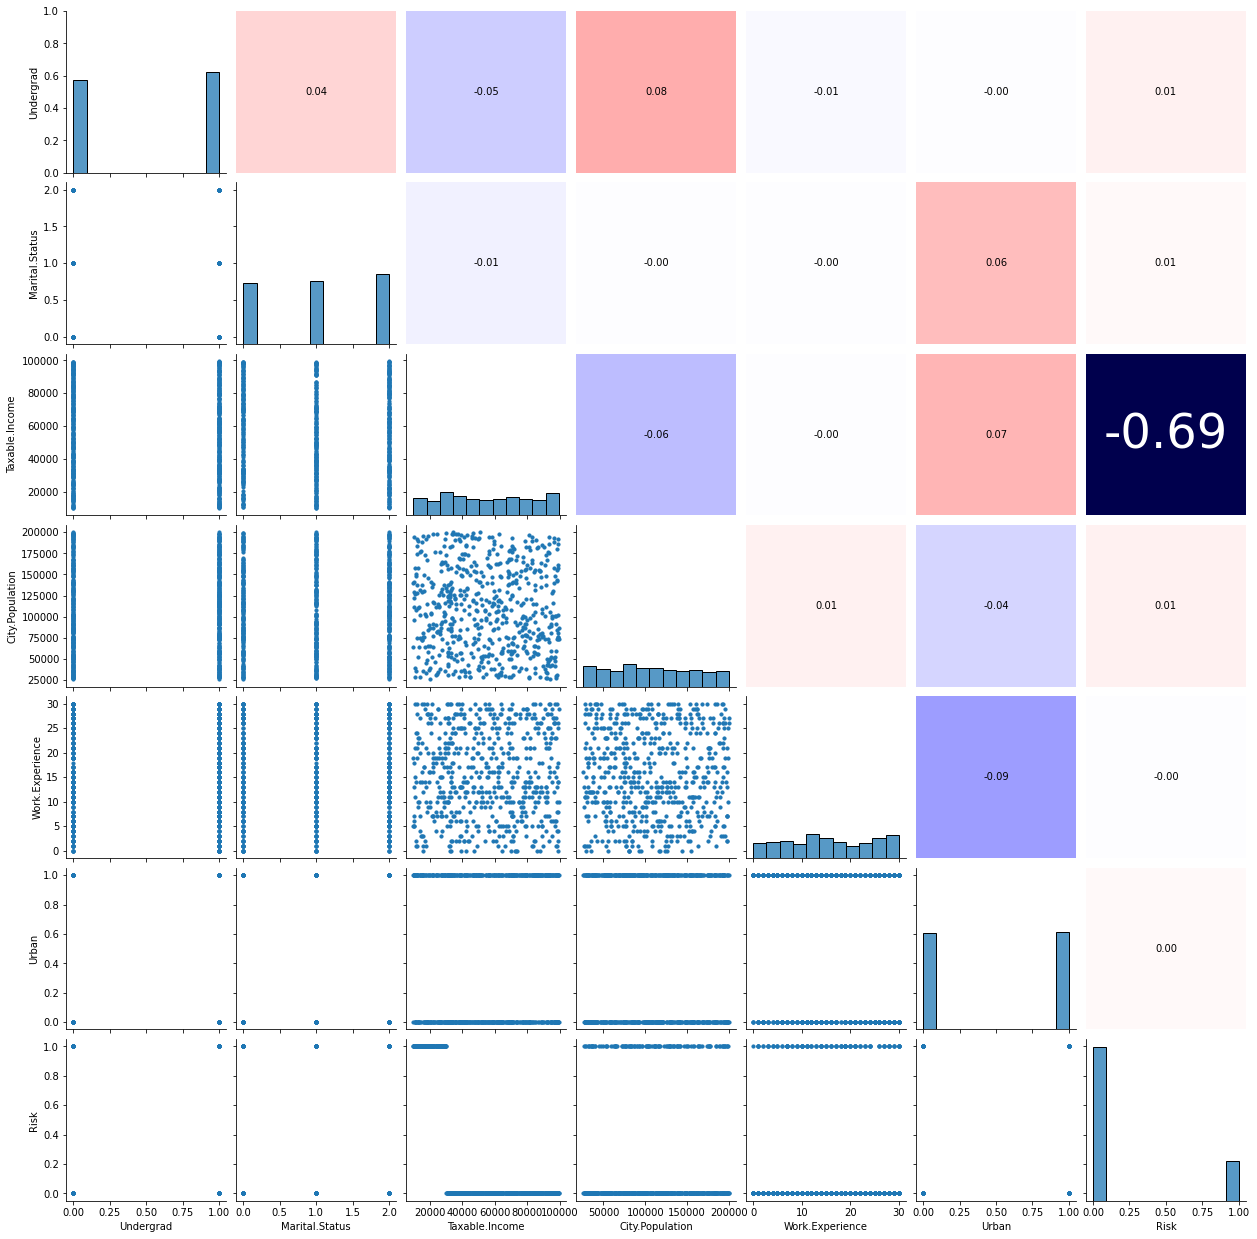

In [44]:
# pairplot with correation

def corrfunc(x, y, **kwds):
    cmap = kwds['cmap']
    norm = kwds['norm']
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sn.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3]) ) / 2
    tam = int(70*abs(r))
    if tam < 10:
        tam = 10
    ax.annotate(f"{r:.2f}", xy=(.5, .5), xycoords=ax.transAxes,
            color='white' if lightness < 0.7 else 'black', size=tam, ha='center', va='center')


g = sn.PairGrid(new_df)
g.map_lower(plt.scatter, s=10)
g.map_diag(sn.histplot, kde=False)
g.map_upper(corrfunc, cmap=plt.get_cmap('seismic'), norm=plt.Normalize(vmin=-.5, vmax=.5))
g.fig.subplots_adjust(wspace=0.06, hspace=0.06) 
plt.show()

In [45]:
# Splitting our data
x_train,x_test,y_train,y_test=train_test_split(new_df.iloc[:,:-1],new_df.iloc[:,-1],stratify=df.iloc[:,-1])

In [46]:
# Model building
model=DecisionTreeClassifier(random_state=11)
model.fit(x_train,y_train)

DecisionTreeClassifier(random_state=11)

In [47]:
# Since we have a imbalanced data we will use accuracy score
# defining a function to check scores
def check_my_score(model,x_train,x_test,y_train,y_test):
    train_cm=confusion_matrix(y_train,model.predict(x_train))
    test_cm=confusion_matrix(y_test,model.predict(x_test))

    # plotting confusion metrics
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1,title='Train set')
    sn.heatmap(train_cm,annot=True,fmt=".0f",cmap='copper',cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1,2,2,title='Test set')
    sn.heatmap(test_cm,annot=True,fmt=".0f",cbar=False)
    plt.show()

    # Classification reports
    print('On training set :\n ',classification_report(y_train,model.predict(x_train)))
    print('\n On testing set :\n ',classification_report(y_test,model.predict(x_test)))

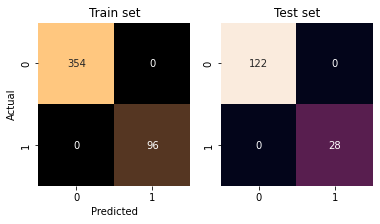

On training set :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       354
         1.0       1.00      1.00      1.00        96

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450


 On testing set :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       122
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [48]:
check_my_score(model,x_train,x_test,y_train,y_test)

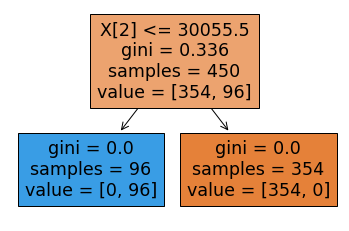

In [49]:
# plotting the tree

_=tree.plot_tree(model,filled=True)

In [50]:
# Lets check the feature importances
px.bar(y=model.feature_importances_,x=x_train.columns)

Seems like only Taxable income holds 100% of prediction power

In [51]:
# So using Taxable.Income we will build a new model 
new_x_train,new_x_test=x_train['Taxable.Income'].values.reshape(-1,1),x_test['Taxable.Income'].values.reshape(-1,1)

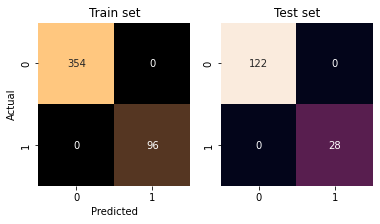

On training set :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       354
         1.0       1.00      1.00      1.00        96

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450


 On testing set :
                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       122
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [52]:
# Fitting the model
model_1=DecisionTreeClassifier(random_state=11)
model_1.fit(new_x_train,y_train)

# Checking scores
check_my_score(model_1,new_x_train,new_x_test,y_train,y_test)

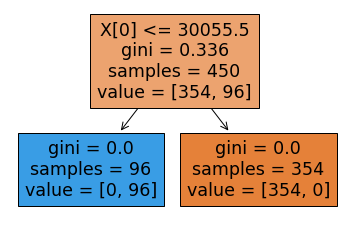

In [53]:
# plotting the tree

_=tree.plot_tree(model_1,filled=True)

So there we have a model which quiet good.<br>

Not the best as our actual condition was 30000,<br>
where as model seperate them with a condition below 30206  

In [54]:
# NO need of bagging as our accuracy is high

# Storing the result

new_df['Predicted']=model_1.predict(new_df['Taxable.Income'].values.reshape(-1,1))

In [55]:
# Adding label to them
for i in range(2):
    new_df.iloc[:,-i-1]=new_df.iloc[:,-i-1].apply(lambda x:{1:'Risky',0:'Good'}[x])

In [56]:
new_df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,Risk,Predicted
0,0,2,68833,50047,10,1,Good,Good
1,1,0,33700,134075,18,1,Good,Good
2,0,1,36925,160205,30,1,Good,Good
3,1,2,50190,193264,15,1,Good,Good
4,0,1,81002,27533,28,0,Good,Good
...,...,...,...,...,...,...,...,...
595,1,0,76340,39492,7,1,Good,Good
596,1,0,69967,55369,2,1,Good,Good
597,0,0,47334,154058,0,1,Good,Good
598,1,1,98592,180083,17,0,Good,Good
